# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


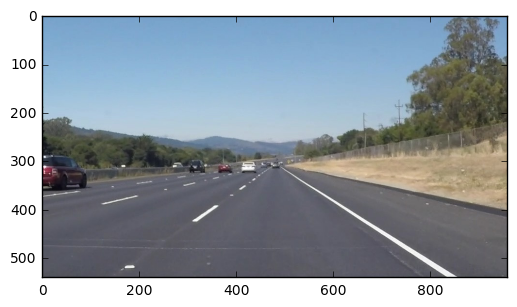

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [77]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)



def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



# jkm - tempchange this to 10, 5 
def draw_lines(img, lines, color=[255, 0, 0], thickness=5 ):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [78]:
import os
os.listdir("test_images/")


['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg']

run your solution on all test_images and make copies into the test_images directory).

Image jpg list is: ['solidYellowLeft.jpg', 'solidYellowCurve.jpg', 'solidWhiteRight.jpg', 'solidWhiteCurve.jpg', 'whiteCarLaneSwitch.jpg', 'solidYellowCurve2.jpg']

 Getting Image:  solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


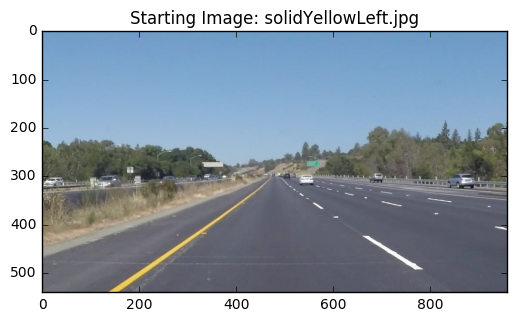

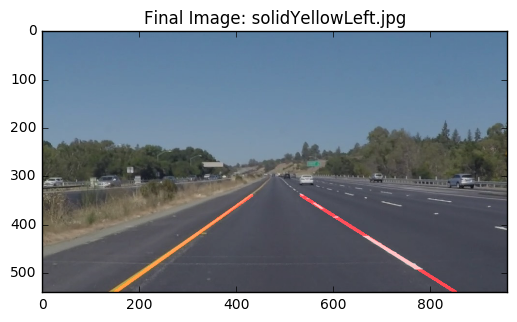


 Writing Image:  FinalsolidYellowLeft.jpg

 Getting Image:  solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


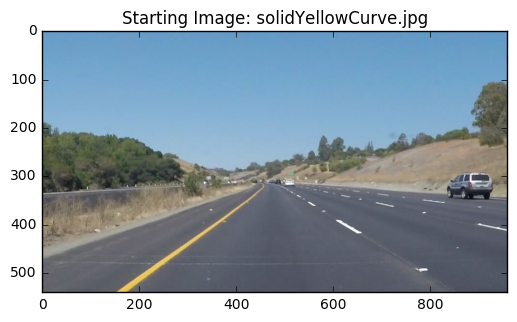

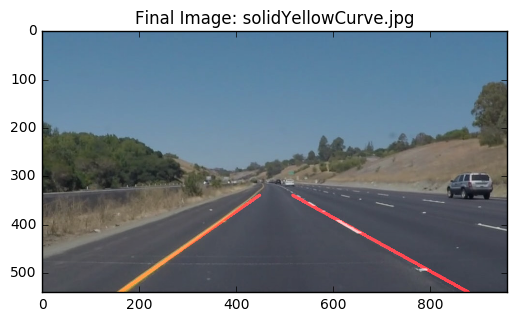


 Writing Image:  FinalsolidYellowCurve.jpg

 Getting Image:  solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


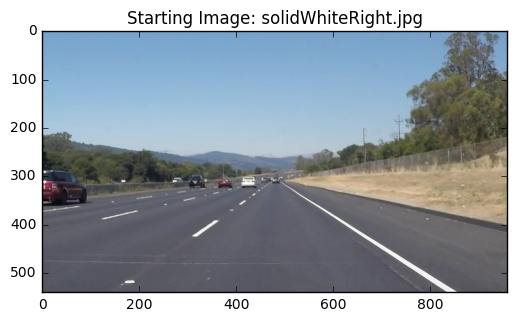

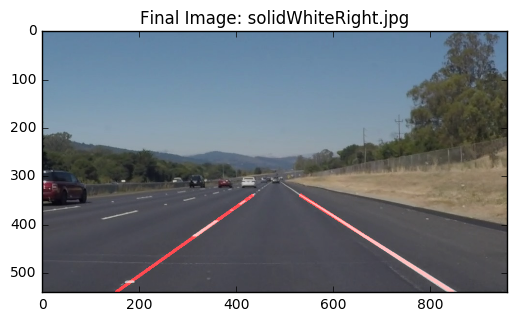


 Writing Image:  FinalsolidWhiteRight.jpg

 Getting Image:  solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


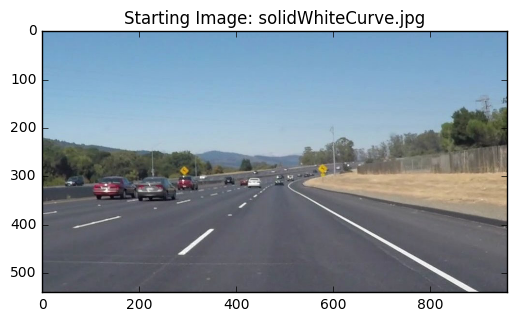

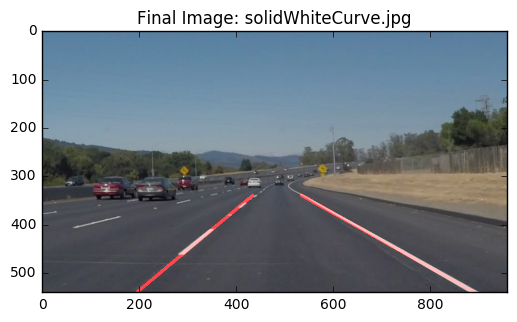


 Writing Image:  FinalsolidWhiteCurve.jpg

 Getting Image:  whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


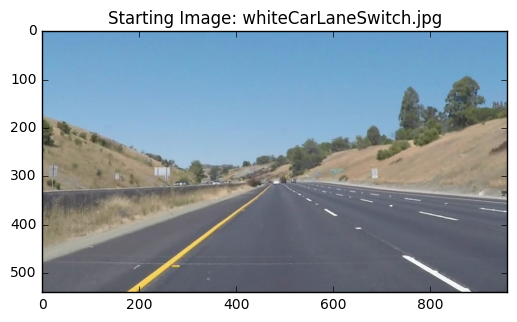

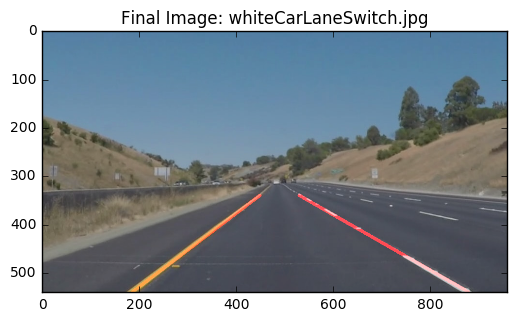


 Writing Image:  FinalwhiteCarLaneSwitch.jpg

 Getting Image:  solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


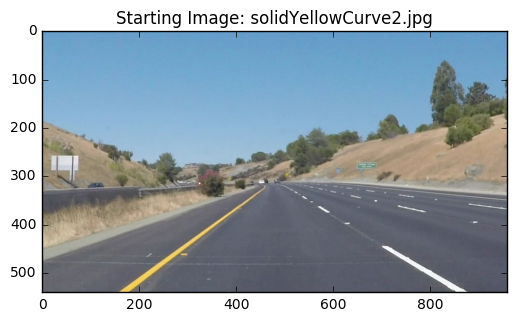

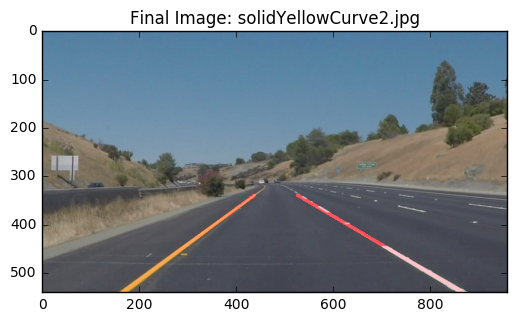


 Writing Image:  FinalsolidYellowCurve2.jpg


In [80]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def reject_outliers(slopes, m=2):
    s = slopes
    if len(s) > 2:
        s = slopes[abs(slopes - np.mean(slopes)) < m * np.std(slopes)]
    return s


#def split_lines(lines, vertices):
#    """ split the lines into 2 groups, left and right"""

def draw_one_line(img, lines, slopes, points_x1, vertices, color, thickness= 8):
    """Draw one of the extrapolated lines on one side.
           lines: np array of lines in the set on that side
           slopes: np array of slopes of the lines
           points_px1: np array of the predicted px1 for each line
    """
    DEBUG = 0
    DEBUG2 = 0
    # roi_py1, roi_py2, roi_px1_l, roi_px2_r
    (ax, ay), (bx, by), (cx, cy), (dx,dy) = vertices[0] # this is the roi points
    if len(lines) > 2: # was 0, 
        # only if there was data for that side
        slopes_good= reject_outliers(slopes)
        slope_avg = np.average(slopes_good)
        points_x1_good= reject_outliers(points_x1)
        px1_avg = abs(np.average(points_x1_good))
        px2_calc = ((by - ay)/slope_avg) + px1_avg
        if DEBUG:
            print("lines", lines)
            print( "ax, ay, bx, by, cx, cy, dx,dy", ax, ay, bx, by, cx, cy, dx,dy)
            print("slopes", slopes)
            print("good slopes", slopes_good)
            print("slope avg: ", slope_avg)
            print("points x1", points_x1)
            print("good points x1: ", points_x1_good)
            print("px1_avg", px1_avg)
            print("px2_calc", px2_calc)
        #
        # Now draw the final line
        px1 = int(round(px1_avg)) 
        px2 = int(round(px2_calc))    
        if DEBUG: print( "P1 P2", (px1, ay), (px2, by) )
        # draw if within the roi 
        # be more generous on the top part of our roi
        if (ax <= px1 <= dx) and (ax <= px2 <= dx):
            cv2.line(img, (px1, ay), (px2, by), color, thickness)
        else:
            if DEBUG2: 
                print("NOT Drawing extrapolated line", (px1, ay), (px2, by)  )
                print("lines", lines)
                print( "ax, ay, bx, by, cx, cy, dx,dy", ax, ay, bx, by, cx, cy, dx,dy)
                print("slopes", slopes)
                print("good slopes", slopes_good)
                print("slope avg: ", slope_avg)
                print("points x1", points_x1)
                print("good points x1: ", points_x1_good)
                print("px1_avg", px1_avg)
                print("px2_calc", px2_calc)    


def my_draw_lines(img, lines, vertices , color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the lpy1eft
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    DEBUG = 0
    left = []
    left_m = []
    right= []
    right_m = []
    ROI_PY2 = vertices[0][1][1] # 340   
    ROI_PY1 = vertices[0][0][1] # 540
    left_px1 = []
    right_px1 = []
    for line in lines:
        if DEBUG:  print(line)
        for x1,y1,x2,y2 in line:
            if ((y2-y1 == 0 ) or (x2-x1 == 0)): 
                if DEBUG: print("skipping line: ", line)
            else:
                m = (y2-y1)/(x2-x1)
                # Let's keep only reasonable anglesfrom .2 to 0.8
                # I feel this is a cluge
                if (0.1 <= abs(m) <= 0.9):
                    px1 = x1 - (y1 - ROI_PY1)/m        
                    if m < 0:                
                        left.append(line)
                        left_m.append(m)
                        left_px1.append(px1)           
                    else:                
                        right.append(line)
                        right_m.append(m)
                        right_px1.append(px1)    
                    #
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # 
    # draw left line
    draw_one_line(img, np.array(left), np.array(left_m), np.array(left_px1), vertices, color, thickness)
    """
    if len(left) > 0:
        # only if there was data for the left side
        left_array = np.array(left)           #right_px2_avg = np.average(right_px2)
        left_m_avg = np.average(left_m)
        left_px1_avg = np.average(left_px1)
        left_px2_calc = ((ROI_PY2 - ROI_PY1)/left_m_avg) + left_px1_avg
        if DEBUG:
            print(" left array lines: ", left_array)
            print("left_m:", left_m)
            print("left_m_avg:", left_m_avg)
            print("left_px1", left_px1)
            print("left_px1_avg", left_px1_avg)
            print("left_px2_calc", left_px2_calc)
        #
        # Now draw the final lines
        l_px1 = int(round(left_px1_avg)) 
        l_px2 = int(round(left_px2_calc))    
        if DEBUG: print( "Left P1 P2", (l_px1, ROI_PY1), (l_px2, ROI_PY2) )    
        cv2.line(img, (l_px1, ROI_PY1), (l_px2, ROI_PY2), color, thickness)
    """    
    #
    # Right
    draw_one_line(img, np.array(right), np.array(right_m), np.array(right_px1), vertices, color, thickness)
    '''
    if len (right) > 0:
        # Only if there was data for the right side
        right_array = np.array(right)
        right_m_avg = np.average(right_m)
        right_px1_avg = np.average(right_px1)
        right_px2_calc = ((ROI_PY2- ROI_PY1)/right_m_avg) + right_px1_avg
        #                  
        # Now draw the final lines
        r_px1 = int(round(right_px1_avg))
        r_px2 = int(round(right_px2_calc))                   
        if DEBUG: print("Right P1 P2: ", (r_px1, ROI_PY1), (r_px2, ROI_PY2))                  
        cv2.line(img, (r_px1, ROI_PY1), (r_px2, ROI_PY2), color, thickness)
    '''
        
def my_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)  
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    my_draw_lines(line_img, lines, vertices)
    return line_img


def print_my_image(image, title, img, gray=True):
    '''
    To print the image
    '''
    if gray: 
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.title(title + img)
    plt.show() 

# This is the "pipeline"
def my_process_image(image, print_image=True):
    """
    Do all the steps to process one image. 
    If print_image=TRue then print out intermediary images. This should only be done during dev & debug. of 
      processing single images.
    """
    DEBUG=False
    # Step 1 - Show the original image
    if print_image: print_my_image(image, 'Original Image: ', img, gray=False)
    #    
    # Step 2: Convert to gray scale and show that.
    gray = grayscale(image)
    if print_image: print_my_image(gray, 'Gray: ', img, gray=True)
    #
    # Step2.1 might needto add another step here to better work with yello pixels.
    #yellow_gray = cv2.inRange(gray, 20w0, 255)
    #
    # Step 3: Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)
    if print_image: print_my_image(blur_gray, 'Blur Gray: ', img, gray=True)  
    #
    # Step 4: Define the  parameters for Canny and apply
    low_threshold = 50    
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    if print_image: print_my_image(edges, 'Canny Edges: ', img, gray=True)
    #
    # Step 5: Determine the vertices for the image, and apply the mask
    #         JKM TO DO: Should try to make this propotion to image shape rather then hard coding
    imshape = image.shape
    if DEBUG: print("Image Shape", imshape)
    #vertices = np.array([[(150,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    # sat-sun vertices = np.array([[(10,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(10,imshape[0]),(450, 340), (490, 340), (imshape[1],imshape[0])]], dtype=np.int32)
    if DEBUG: print("vertices", vertices)
    masked_edges = region_of_interest(edges, vertices)
    if print_image: print_my_image(masked_edges, 'Masked Edges: ', img, gray=True)
    #
    # Step 6: Define the Hough transform parameters & Run Hough on edge detected image
    # Make a blank the same size as our image to draw on
    rho = 2 
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line orig = 5
    max_line_gap = 20    # maximum gap in pixels between connectable line segments orig 1
    #
    # Output "lines" is an array containing endpoints of detected line segments
    lines = my_hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, vertices)
    if print_image: print_my_image(lines, 'Hough Lines: ', img, gray=False)
    #
    # Step 7: Apply/Draw our Hough lines on the original image.
    # Draw the lines on the edge image
    final_image = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    if print_image: print_my_image(final_image, 'Final Image: ', img, gray=False)
    #
    return final_image

# Start of my "main"
JKM_DEBUG=1

my_img_list = os.listdir("test_images/")

if JKM_DEBUG: print("Image jpg list is:", my_img_list)
    
for img in my_img_list:
#for img in [my_img_list[4]]: # JKM tmp just one image for now
    if JKM_DEBUG: print("\n Getting Image: ", img)
    image = mpimg.imread('test_images/' + img)
    #printing out some stats and plotting
    if JKM_DEBUG: print('This image is:', type(image), 'with dimesions:', image.shape)    
    # print the original image 
    if JKM_DEBUG: print_my_image(image, 'Starting Image: ', img, gray=False)
    #
    # process the final image and print
    final = my_process_image(image, print_image=False)
    if JKM_DEBUG: print_my_image(final, 'Final Image: ', img, gray=True)
    #   
    if JKM_DEBUG: print("\n Writing Image: ", 'Final' + img)
    mpimg.imsave('test_images/' + 'Final' + img, final)    


    


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [81]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [82]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    result = my_process_image(image, print_image=False)
    return result

Let's try the one with the solid white lane on the right first ...

In [83]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:33<00:00,  3.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2min 40s, sys: 6.7 s, total: 2min 47s
Wall time: 35.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [101]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [84]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:51<00:00,  7.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9min 51s, sys: 22.4 s, total: 10min 13s
Wall time: 1min 54s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### My Thoughts:
1. My lane finding algorithm seemed to work adequately for the still images and the videos when just drawing the lines found by the Hough algorithm. 

2. However, once modifyng the algorithm to support a continuous line on lane edges, by extrapolating from lane lines produced by Hough transform, it did not work so well. The technique I used to do the extrapolation seemed not very robust, and was prone to errors due to unexpected elements in the video images. I had to make a number of "cluge" assumptions, such as what a lane line angle might be, in order to make it work. A more sophisticated and yet simple technique should be used instead. Perhaps a linear regression approach would have been better?  As well, more exploration on getting cleaner data from Hough transformations should be explored, if this is to be used going forward.

3. Also, when working with the video, one can see that the extrapolated lane line dissapears momentarily and results in a "jumpy" lane line on the video. A technique of continuity between the individual images in the running video should be explored. The extraploated lane line from one still image to the next image should be used to smooth out the display of the lane line detection.   

4. The approach that I used for extrapolating and making the  lane lines constant, will work even more poorly on curved lanes, or where the lines are not detected due to weather or road conditions, or when something obscures the  lines temporarily like an object passing over some lines in front of the  vehicle (like a car changing lanes in front of you). 

5. Overall, I wasn't very satisfied with the quality of my submission, although it should probably meet the rubric criteria for the  project specifications (and this  is  all the  time that I can devote to it for now! until I get feedback.)  Please let me know if I still need to do more to pass the rubric criteria. 

6. I tried the extra project, and saw that I had a lot of extraneous elements an dlines in my image. It must be that I am not getting the ROI (region of interest) adequately. Or I am not filtering the results of my Hough transform to be in the rOI properly? I just don't know why 


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [85]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [01:03<00:00,  3.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 4min 24s, sys: 12.3 s, total: 4min 36s
Wall time: 1min 7s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))